
# $K^* \mu \mu$ angular analysis - Getting started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit
import json

## Loading the predictions

Adapting code from the predictions notebook - they do the JSON->pandas conversion for us!

In [2]:
si_preds = {}
pi_preds = {}
with open("predictions/std_predictions_si.json","r") as _f:
    si_preds = json.load(_f)
with open("predictions/std_predictions_pi.json","r") as _f:
    pi_preds = json.load(_f)

si_pred_list = []
pi_pred_list = []

for _binNo in si_preds.keys():
    si_frame = pd.DataFrame(si_preds[_binNo]).transpose()
    si_pred_list.append(si_frame)

for _binNo in pi_preds.keys():
    pi_frame = pd.DataFrame(pi_preds[_binNo]).transpose()
    si_pred_list.append(si_frame)

si_pred_list[0]

,val,err
FL,0.296448,0.050642
AFB,-0.097052,0.008421
S3,0.010876,0.006028
S4,0.090919,0.006011
S5,0.252907,0.010621
S7,-0.020672,0.016901
S8,-0.002153,0.009466
S9,-0.000701,0.007420


In [3]:
si_pred_list[0].loc["FL","val"]
#          bin no   var  val/err

0.2964476598667644

## Loading the data

Taking total_dataset.pkl and splitting into bins using bit from Voltron V4

In [4]:
df = pd.read_pickle("data/total_dataset.pkl")

# %% bin splitting
# I'm sure there's a more elegant solution but I can't think of one right now.

bin0 = df[(df['q2'] > 0.1) & (df['q2'] <= 0.98)]
bin1 = df[(df['q2'] > 1.1) & (df['q2'] <= 2.5)]
bin2 = df[(df['q2'] > 2.5) & (df['q2'] <= 4.0)]
bin3 = df[(df['q2'] > 4.0) & (df['q2'] <= 6.0)]
bin4 = df[(df['q2'] > 6.0) & (df['q2'] <= 8.0)]
bin5 = df[(df['q2'] > 15.0) & (df['q2'] <= 17.0)]
bin6 = df[(df['q2'] > 17.0) & (df['q2'] <= 19.0)]
bin7 = df[(df['q2'] > 11.0) & (df['q2'] <= 12.5)]
bin8 = df[(df['q2'] > 1.0) & (df['q2'] <= 6.0)] # ???
# we're only given toy data up to bin 6, so how can we check that this isn't a mistake?
bin9 = df[(df['q2'] > 15.0) & (df['q2'] <= 17.9)]

bins_orig = [bin0, bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]

bins_orig[0].head()

,mu_plus_MC15TuneV1_ProbNNk,mu_plus_MC15TuneV1_ProbNNpi,mu_plus_MC15TuneV1_ProbNNmu,mu_plus_MC15TuneV1_ProbNNe,mu_plus_MC15TuneV1_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,mu_plus_PHI,mu_plus_PE,...,J_psi_MM,J_psi_ENDVERTEX_CHI2,J_psi_ENDVERTEX_NDOF,J_psi_FDCHI2_OWNPV,q2,phi,costhetal,costhetak,polarity,year
38,0.047568,0.005351,0.988304,0.000015,0.001760,139512.290636,5341.715703,3.955386,0.328871,139512.330646,...,946.112000,0.019810,1,39.782512,0.895010,-0.091009,0.924565,-0.701023,1.0,2016
49,0.002397,0.458227,0.799403,0.000003,0.002181,19436.459103,1027.328647,3.632637,2.212027,19436.746285,...,766.383000,0.602143,1,219.901569,0.587342,1.572424,-0.309985,0.745204,1.0,2016
78,0.112146,0.026018,0.999261,0.000034,0.062715,131228.580000,3930.650541,4.201059,0.734324,131228.622535,...,672.686294,0.234502,1,1932.640325,0.452382,1.291542,-0.048721,-0.289154,-1.0,2016
84,0.878794,0.024335,0.370556,0.000001,0.024925,27290.440000,2487.040651,3.086507,-0.066417,27290.644534,...,696.163108,1.658864,1,266.264579,0.484600,-0.896506,-0.306216,0.433725,1.0,2016
123,0.000298,0.212780,0.975806,0.000007,0.000239,34916.160455,1933.411343,3.586044,-0.910054,34916.320319,...,970.644000,0.001436,1,60.220613,0.942221,2.868266,0.359784,-0.356637,1.0,2016


## Applying selection criteria

from VoltronV4

In [5]:
# initial guesses
in_gu = [1900, 1900, 16, 16, 16, 16, 1000, 6, 0.1, 0.1, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.95, 0.95, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

def select(df, in_gu):
    # Function to be optimised - it may make sense to make multiple functions that
    # only take into account correlated sets of data - but this can be discussed by
    # Machine learning group
    bgrd, sig = [x for _, x in df.groupby((
        (df['mu_plus_PT'] > in_gu[0]) | (df['mu_minus_PT'] > in_gu[1])) &
        ((df['mu_plus_IPCHI2_OWNPV'] >= in_gu[2]) | (df['mu_minus_IPCHI2_OWNPV'] >= in_gu[3]) | (df['Pi_IPCHI2_OWNPV'] >= in_gu[4]) | (df['K_IPCHI2_OWNPV'] >= in_gu[5])) &
        ((df['B0_FDCHI2_OWNPV'] >= in_gu[6]) & (df['B0_ENDVERTEX_CHI2'] < in_gu[7])) &
        (((df['K_MC15TuneV1_ProbNNk'] >= in_gu[8])) & ((df['K_MC15TuneV1_ProbNNpi'] <= in_gu[10]))) &
        ((df['Pi_MC15TuneV1_ProbNNpi'] >= in_gu[12])) &
        (((df['Pi_MC15TuneV1_ProbNNmu'] <= in_gu[14])) & ((df['mu_minus_MC15TuneV1_ProbNNpi'] <= in_gu[16])) & ((df['mu_minus_MC15TuneV1_ProbNNmu'] >= in_gu[18]))) &
        (((df['K_MC15TuneV1_ProbNNmu'] <= in_gu[20])) & ((df['mu_plus_MC15TuneV1_ProbNNk'] <= in_gu[22]))) & (((df['mu_minus_MC15TuneV1_ProbNNe'] <= in_gu[23])) & ((df['mu_plus_MC15TuneV1_ProbNNe'] <= in_gu[24])) & ((df['K_MC15TuneV1_ProbNNe'] <= in_gu[25])) & ((df['Pi_MC15TuneV1_ProbNNe'] <= in_gu[26]))) &
        (((df['mu_minus_MC15TuneV1_ProbNNp'] <= in_gu[27])) & ((df['mu_plus_MC15TuneV1_ProbNNe'] <= in_gu[28])) & ((df['K_MC15TuneV1_ProbNNe'] <= in_gu[29])) & ((df['Pi_MC15TuneV1_ProbNNe'] <= in_gu[30]))
    ))]
    return bgrd, sig

bins = []

for i in range(len(bins_orig)):
    bin = bins_orig[i]
    bgrd, sig = select(bin, in_gu)
    bins.append(sig)

Let us have a look at the distribution of the variable $cos(\theta_l)$, which will be used below, in one of the bins.

## Fitting
Let us assume a flat acceptance distribution for the following.
We have
$\frac{d^2\Gamma_P}{dq^2dcos\theta_l} = \frac{3}{8}[\frac{3}{2} - \frac{1}{2}F_L + \frac{1}{2}cos2\theta_l(1-3F_L) + \frac{8}{3}A_{FB}cos\theta_l]$

Let us check how the negative log-likelihood function defined above looks like for a given bin and a fixed $A_{FB}$ or a fixed $F_L$.

### Fitting
We then use `iminuit` to optimize $A_{FB}$ and $F_L$.

Let us also look at the profiles for $A_{FB}$ and $F_L$ for a bin (e.g. bin number 0).

We can also plot the resulting fitted PDF over the measured $cos(\theta_l)$ distribution.

Finally, let us visualize the results in each bin.

## $\theta_L$

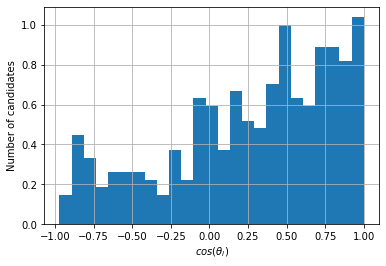

In [6]:
#THETAL
plt.hist(bins[9]['costhetal'], bins=25, density=True)
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.grid()
plt.show()

In [7]:
#THETAL
def d2gamma_p_d2q2_dcosthetal(fl, afb, cos_theta_l):
    """
    Returns the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param cos_theta_l: cos(theta_l)
    :return:
    """
    ctl = cos_theta_l
    c2tl = 2 * ctl ** 2 - 1
    acceptance = 0.5  # acceptance "function"
    scalar_array = 3/8 * (3/2 - 1/2 * fl + 1/2 * c2tl * (1 - 3 * fl) + 8/3 * afb * ctl) * acceptance
    normalised_scalar_array = scalar_array * 2  # normalising scalar array to account for the non-unity acceptance function
    return normalised_scalar_array



In [8]:
#THETAL
def log_likelihoodthetal(fl, afb, _bin): #FOR THETA_L
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    _bin = bins[int(_bin)]
    ctl = _bin['costhetal']
    normalised_scalar_array = d2gamma_p_d2q2_dcosthetal(fl=fl, afb=afb, cos_theta_l=ctl)
    return - np.sum(np.log(normalised_scalar_array))

/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


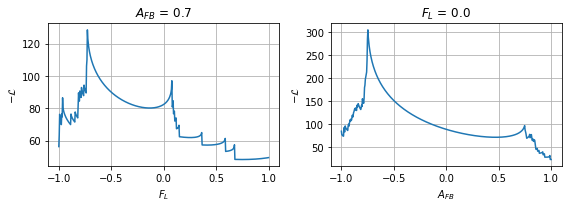

In [9]:
_test_bin = 6  #FOR THETA_L
_test_afb = 0.7
_test_fl = 0.0

x = np.linspace(-1, 1, 500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(x, [log_likelihoodthetal(fl=i, afb=_test_afb, _bin=_test_bin) for i in x])
ax1.set_title(r'$A_{FB}$ = ' + str(_test_afb))
ax1.set_xlabel(r'$F_L$')
ax1.set_ylabel(r'$-\mathcal{L}$')
ax1.grid()
ax2.plot(x, [log_likelihoodthetal(fl=_test_fl, afb=i, _bin=_test_bin) for i in x])
ax2.set_title(r'$F_{L}$ = ' + str(_test_fl))
ax2.set_xlabel(r'$A_{FB}$')
ax2.set_ylabel(r'$-\mathcal{L}$')
ax2.grid()
plt.tight_layout()
plt.show()

In [10]:
#FOR THETA_L
bin_number_to_check = 8 # bin that we want to check in more details in the next cell
bin_results_to_check = None

log_likelihoodthetal.errordef = Minuit.LIKELIHOOD
decimal_places = 3
starting_point = [-0.1,0.0]
fls, fl_errs = [], []
afbs, afb_errs = [], []
for i in range(len(bins)):
    m = Minuit(log_likelihoodthetal, fl=starting_point[0], afb=starting_point[1], _bin=i)
    m.fixed['_bin'] = True  # fixing the bin number as we don't want to optimize it
    m.limits=((-1.0, 1.0), (-1.0,1.0), None)
    m.migrad()
    m.hesse()
    if i == bin_number_to_check:
        bin_results_to_check = m
    fls.append(m.values[0])
    afbs.append(m.values[1])
    fl_errs.append(m.errors[0])
    afb_errs.append(m.errors[1])
    print(f"Bin {i}: {np.round(fls[i], decimal_places)} pm {np.round(fl_errs[i], decimal_places)},", f"{np.round(afbs[i], decimal_places)} pm {np.round(afb_errs[i], decimal_places)}. Function minimum considered valid: {m.fmin.is_valid}")

/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Bin 0: 1.0 pm 0.005, -0.99 pm 1.486. Function minimum considered valid: False
Bin 1: 1.0 pm 0.021, -0.831 pm 0.063. Function minimum considered valid: False
Bin 2: 0.695 pm 0.104, -0.148 pm 0.056. Function minimum considered valid: True
Bin 3: 1.0 pm 0.012, -0.909 pm 0.031. Function minimum considered valid: False
Bin 4: 0.523 pm 0.051, -0.043 pm 0.029. Function minimum considered valid: True
Bin 5: 0.237 pm 0.092, 0.343 pm 0.052. Function minimum considered valid: True
Bin 6: 0.101 pm 0.13, 0.454 pm 0.069. Function minimum considered valid: True
Bin 7: 0.455 pm 0.07, 0.046 pm 0.04. Function minimum considered valid: True
Bin 8: 0.638 pm 0.047, -0.292 pm 0.028. Function minimum considered valid: False
Bin 9: 0.164 pm 0.08, 0.406 pm 0.044. Function minimum considered valid: True


/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/iminuit/minuit.py:1449: IMinuitWarning: MIGRAD fails to converge for fl=0.6238234562804872
  warnings.warn(


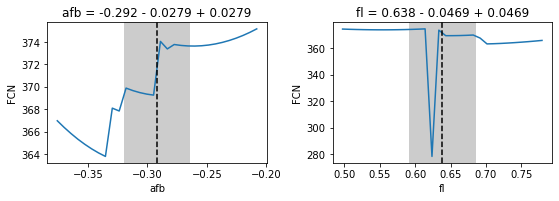

In [11]:
#FOR THETA_L
plt.figure(figsize=(8, 5))
plt.subplot(221)
bin_results_to_check.draw_mnprofile('afb', bound=3)
plt.subplot(222)
bin_results_to_check.draw_mnprofile('fl', bound=3)
plt.tight_layout()
plt.show()

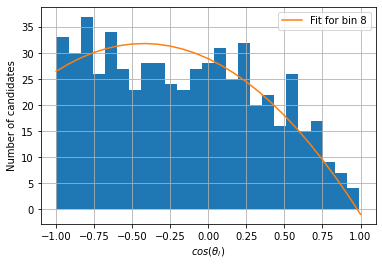

In [12]:
#THETA L
bin_to_plot = 8
number_of_bins_in_hist = 25
cos_theta_l_bin = bins[bin_to_plot]['costhetal']
hist, _bins, _ = plt.hist(cos_theta_l_bin, bins=number_of_bins_in_hist)
x = np.linspace(-1, 1, number_of_bins_in_hist)
pdf_multiplier = np.sum(hist) * (np.max(cos_theta_l_bin) - np.min(cos_theta_l_bin)) / number_of_bins_in_hist
y = d2gamma_p_d2q2_dcosthetal(fl=fls[bin_to_plot], afb=afbs[bin_to_plot], cos_theta_l=x) * pdf_multiplier
plt.plot(x, y, label=f'Fit for bin {bin_to_plot}')
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.legend()
plt.grid()
plt.show()

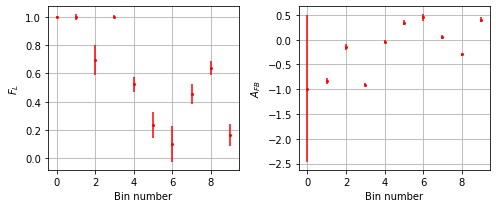

In [13]:
#THETAL
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), fls, yerr=fl_errs, fmt='o', markersize=2, label=r'$F_L$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), afbs, yerr=afb_errs, fmt='o', markersize=2, label=r'$A_{FB}$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$F_L$')
ax2.set_ylabel(r'$A_{FB}$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()


## $\phi$

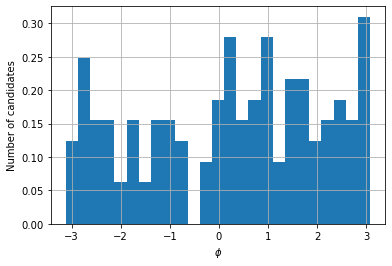

In [14]:
#PHI
plt.hist(bins[6]['phi'], bins=25, density=True)
plt.xlabel(r'$\phi$')
plt.ylabel(r'Number of candidates')
plt.grid()
plt.show()

In [15]:
#PHI
def d2gamma_p_d2q2_dphi(s3, s9, phi):
    """
    Returns the pdf defined above
    :param s3: s3 observable
    :param s9: s9 observable
    :param phi: phi
    :return:
    """

    acceptance = 0.5  # acceptance "function"
    scalar_array = 1/(2*np.pi)*(1+s3*np.cos(2*phi)+s9*np.sin(2*phi)) * acceptance
    normalised_scalar_array = scalar_array * 2  # normalising scalar array to account for the non-unity acceptance function
    return normalised_scalar_array


In [16]:
#PHI
def log_likelihoodphi(s3, s9, _bin): #FOR PHI
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    _bin = bins[int(_bin)]
    Phi = _bin['phi']
    normalised_scalar_array = d2gamma_p_d2q2_dphi(s3=s3, s9=s9, phi=Phi)
    return - np.sum(np.log(normalised_scalar_array))

/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


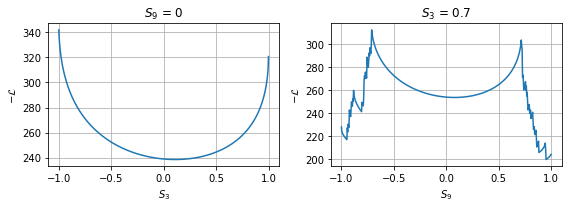

In [17]:
_test_bin = 6  #FOR PHI
_test_s3 = 0.7
_test_s9 = 0

x = np.linspace(-1, 1, 500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(x, [log_likelihoodphi(s3=i, s9=_test_s9, _bin=_test_bin) for i in x])
ax1.set_title(r'$S_9$ = ' + str(_test_s9))
ax1.set_xlabel(r'$S_3$')
ax1.set_ylabel(r'$-\mathcal{L}$')
ax1.grid()
ax2.plot(x, [log_likelihoodphi(s3=_test_s3, s9=i, _bin=_test_bin) for i in x])
ax2.set_title(r'$S_3$ = ' + str(_test_s3))
ax2.set_xlabel(r'$S_9$')
ax2.set_ylabel(r'$-\mathcal{L}$')
ax2.grid()
plt.tight_layout()
plt.show()

In [18]:
#FOR PHI
bin_number_to_check = 6  # bin that we want to check in more details in the next cell
bin_results_to_check = None

log_likelihoodphi.errordef = Minuit.LIKELIHOOD
decimal_places = 3
starting_point = [-0.25,0.0]
s3s, s3_errs = [], []
s9s, s9_errs = [], []
for i in range(len(bins)):
    m = Minuit(log_likelihoodphi, s3=starting_point[0], s9=starting_point[1], _bin=i)
    m.fixed['_bin'] = True  # fixing the bin number as we don't want to optimize it
    m.limits=((-0.5, 0.5), (-0.5, 0.5), None)
    m.migrad()
    m.hesse()
    if i == bin_number_to_check:
        bin_results_to_check = m
    s3s.append(m.values[0])
    s9s.append(m.values[1])
    s3_errs.append(m.errors[0])
    s9_errs.append(m.errors[1])
    print(f"Bin {i}: S3={np.round(s3s[i], decimal_places)} pm {np.round(s3_errs[i], decimal_places)},", f" S9={np.round(s9s[i], decimal_places)} pm {np.round(s9_errs[i], decimal_places)}. Function minimum considered valid: {m.fmin.is_valid}")

Bin 0: S3=-0.086 pm 0.086,  S9=0.107 pm 0.084. Function minimum considered valid: True
Bin 1: S3=-0.131 pm 0.115,  S9=0.135 pm 0.11. Function minimum considered valid: True
Bin 2: S3=-0.013 pm 0.107,  S9=-0.216 pm 0.104. Function minimum considered valid: True
Bin 3: S3=0.17 pm 0.09,  S9=-0.068 pm 0.088. Function minimum considered valid: True
Bin 4: S3=-0.04 pm 0.051,  S9=-0.052 pm 0.05. Function minimum considered valid: True
Bin 5: S3=-0.294 pm 0.086,  S9=0.063 pm 0.087. Function minimum considered valid: True
Bin 6: S3=0.099 pm 0.119,  S9=0.157 pm 0.125. Function minimum considered valid: True
Bin 7: S3=-0.029 pm 0.07,  S9=-0.038 pm 0.067. Function minimum considered valid: True
Bin 8: S3=0.024 pm 0.059,  S9=-0.047 pm 0.057. Function minimum considered valid: True
Bin 9: S3=-0.154 pm 0.076,  S9=0.063 pm 0.075. Function minimum considered valid: True


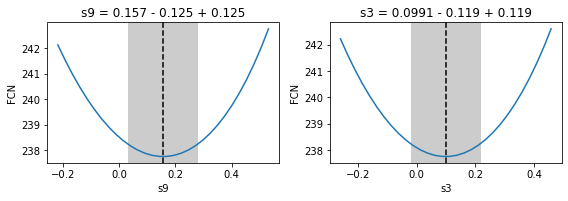

In [19]:
#FOR PHI
plt.figure(figsize=(8, 5))
plt.subplot(221)
bin_results_to_check.draw_mnprofile('s9', bound=3)
plt.subplot(222)
bin_results_to_check.draw_mnprofile('s3', bound=3)
plt.tight_layout()
plt.show()

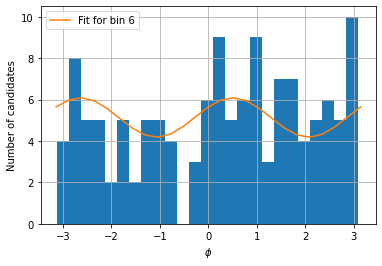

In [20]:
# PHI
bin_to_plot = 6
number_of_bins_in_hist = 25
phi_bin = bins[bin_to_plot]['phi']
hist, _bins, _ = plt.hist(phi_bin, bins=number_of_bins_in_hist)
x = np.linspace(-np.pi, np.pi, number_of_bins_in_hist)
pdf_multiplier = np.sum(hist) * (np.max(phi_bin) - np.min(phi_bin)) / number_of_bins_in_hist
y = d2gamma_p_d2q2_dphi(s3=s3s[bin_to_plot], s9=s9s[bin_to_plot], phi=x) * pdf_multiplier
plt.plot(x, y, label=f'Fit for bin {bin_to_plot}')
plt.xlabel(r'$\phi$')
plt.ylabel(r'Number of candidates')
plt.legend()
plt.grid()
plt.show()

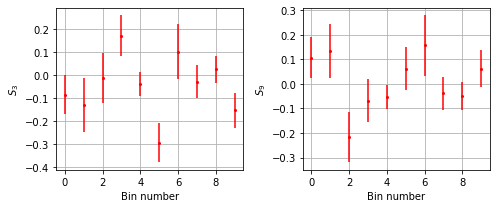

In [21]:
#PHI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s3s, yerr=s3_errs, fmt='o', markersize=2, label=r'$S_3$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s9s, yerr=s9_errs, fmt='o', markersize=2, label=r'$S_9$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$S_3$')
ax2.set_ylabel(r'$S_9$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()

## $\theta_K$

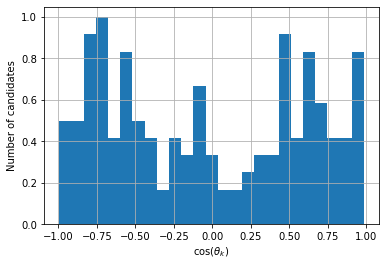

In [22]:
#THETAK
plt.hist(bins[1]['costhetak'], bins=25, density=True)
plt.xlabel(r'$\cos(\theta_k)$')
plt.ylabel(r'Number of candidates')
plt.grid()
plt.show()

In [23]:
#THETAK
def d2gamma_p_d2q2_dcosthetak(fl, cos_theta_k):
    """
    Returns the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param cos_theta_k: cos(theta_k)
    :return:
    """
    ctk = cos_theta_k
    acceptance = 0.5  # acceptance "function"
    scalar_array = 3/4 * ((3*fl-1)*ctk**2 +(1-fl)) * acceptance
    normalised_scalar_array = scalar_array * 2  # normalising scalar array to account for the non-unity acceptance function
    return normalised_scalar_array


In [24]:
def log_likelihoodthetak(fl, _bin): #FOR THETA_K
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    _bin = bins[int(_bin)]
    ctk = _bin['costhetak']
    normalised_scalar_array = d2gamma_p_d2q2_dcosthetak(fl=fl, cos_theta_k=ctk)
    return - np.sum(np.log(normalised_scalar_array))

/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


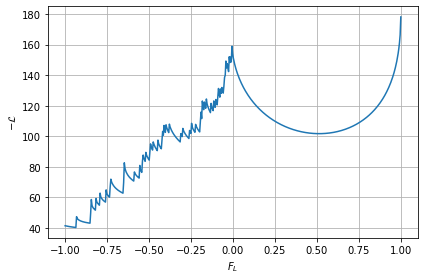

In [25]:
_test_bin = 1  #FOR THETA_K


x = np.linspace(-1, 1, 500)
plt.plot(x, [log_likelihoodthetak(fl=i, _bin=_test_bin) for i in x])
plt.xlabel(r'$F_L$')
plt.ylabel(r'$-\mathcal{L}$')
plt.grid()
plt.tight_layout()
plt.show()

In [26]:
#FOR THETA_K
bin_number_to_check = 0  # bin that we want to check in more details in the next cell
bin_results_to_check = None

log_likelihoodthetak.errordef = Minuit.LIKELIHOOD
decimal_places = 3
starting_point = [0.5]
fls, fl_errs = [], []

for i in range(len(bins)):
    m = Minuit(log_likelihoodthetak, fl=starting_point[0], _bin=i)
    m.fixed['_bin'] = True  # fixing the bin number as we don't want to optimize it
    m.limits=((-0.2, 1.0), None)
    m.migrad()
    m.hesse()
    if i == bin_number_to_check:
        bin_results_to_check = m
    fls.append(m.values[0])
    fl_errs.append(m.errors[0])
    print(f"Bin {i}: {np.round(fls[i], decimal_places)} pm {np.round(fl_errs[i], decimal_places)}. Function minimum considered valid: {m.fmin.is_valid}")

Bin 0: 0.178 pm 0.041. Function minimum considered valid: True
Bin 1: 0.514 pm 0.067. Function minimum considered valid: True
Bin 2: 0.614 pm 0.056. Function minimum considered valid: True
Bin 3: 0.551 pm 0.049. Function minimum considered valid: True
Bin 4: 0.519 pm 0.028. Function minimum considered valid: True
Bin 5: 0.283 pm 0.047. Function minimum considered valid: True
Bin 6: 0.187 pm 0.059. Function minimum considered valid: True
Bin 7: 0.391 pm 0.038. Function minimum considered valid: True
Bin 8: 0.559 pm 0.032. Function minimum considered valid: True
Bin 9: 0.233 pm 0.038. Function minimum considered valid: True


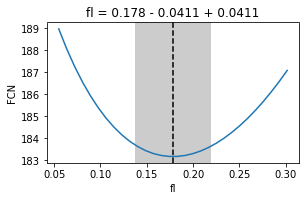

In [27]:
#FOR THETA_K
plt.figure(figsize=(8, 5))
plt.subplot(222)
bin_results_to_check.draw_mnprofile('fl', bound=3)
plt.tight_layout()
plt.show()

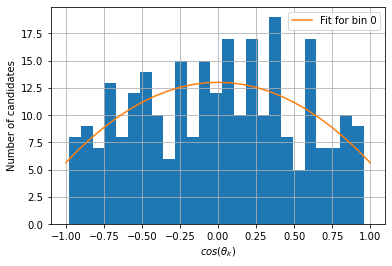

In [28]:
#THETA K

bin_to_plot = 0 #select the bin to plot
number_of_bins_in_hist = 25 #number of bins of histogram, for 2D 25X25
cos_theta_k_bin = bins[bin_to_plot]['costhetak']  #creating the bins for the angle
hist, _bins, _ = plt.hist(cos_theta_k_bin, bins=number_of_bins_in_hist)


x = np.linspace(-1, 1, number_of_bins_in_hist)
pdf_multiplier = np.sum(hist) * (np.max(cos_theta_k_bin) - np.min(cos_theta_k_bin)) / number_of_bins_in_hist
y = d2gamma_p_d2q2_dcosthetak(fl=fls[bin_to_plot], cos_theta_k=x) * pdf_multiplier
plt.plot(x, y, label=f'Fit for bin {bin_to_plot}')
plt.xlabel(r'$cos(\theta_k)$')
plt.ylabel(r'Number of candidates')
plt.legend()
plt.grid()
plt.show()

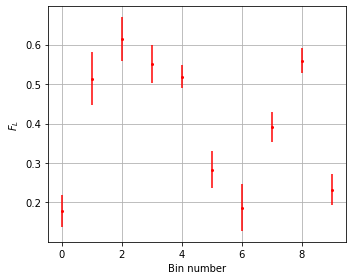

In [29]:
#THETAK
fig, (ax1) = plt.subplots(1, figsize=(5, 4))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), fls, yerr=fl_errs, fmt='o', markersize=2, label=r'$F_L$', color='red')
ax1.grid()
ax1.set_ylabel(r'$F_L$')
ax1.set_xlabel(r'Bin number')

plt.tight_layout()
plt.show()

## $\theta_k + \phi$

In [30]:
def d2gamma_p_d2q2_dphi_dcosthetak(fl,s3, s4, s5, s7, s8, s9, phi,cos_theta_k):
    """
    Returns the pdf defined above
    :param s3: s3 observable
    :param s9: s9 observable
    :param phi: phi
    :return:
    """
    ctk2=cos_theta_k**2
    stk2=1-cos_theta_k**2
    ct2k=ctk2-stk2
    st2k=np.sqrt(1-ct2k**2)
    
    acceptance = 0.5  # acceptance "function"
    scalar_array = (9/(32*np.pi))*(1.5*(1-fl)*(stk2)+2*fl*ctk2-(1/6)*(1-fl)*stk2+(2/3)*fl*ctk2+(4/3)*s3*stk2*np.cos(2*phi)+(2/3)*s4*np.cos(phi)*st2k+(np.pi/2)*s5*st2k*np.cos(phi)+(np.pi/2)*s7*st2k*np.sin(phi)+(2/3)*s8*st2k*np.pi+(4/3)*s9*stk2*np.sin(2*phi)  ) * acceptance
    normalised_scalar_array = scalar_array * 2  # normalising scalar array to account for the non-unity acceptance function
    return normalised_scalar_array


In [31]:
def log_likelihoodphithetak(fl,s3,s4,s5,s7,s8, s9, _bin):
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    _bin = bins[int(_bin)]
    Phi = _bin['phi']
    ctk= _bin['costhetak']
    normalised_scalar_array = d2gamma_p_d2q2_dphi_dcosthetak(fl=fl,s3=s3,s4=s4,s5=s5,s7=s7,s8=s8, s9=s9, phi=Phi,cos_theta_k=ctk)
    return - np.sum(np.log(normalised_scalar_array))

In [32]:
bin_number_to_check = 7  # bin that we want to check in more details in the next cell
bin_results_to_check = None

log_likelihoodphithetak.errordef = Minuit.LIKELIHOOD
decimal_places = 3
starting_point = [0.32,-0.25,-0.31,-0.22,-0.00056,0.000119,0.000169]
fls, fl_errs= [],[]
s3s, s3_errs = [], []
s4s, s4_errs = [], []
s5s, s5_errs = [], []
s7s, s7_errs = [], []
s8s,s8_errs=[],[]
s9s, s9_errs = [], []
for i in range(len(bins)):
    m = Minuit(log_likelihoodphithetak, fl=starting_point[0], s3=starting_point[1],s4=starting_point[2],s5=starting_point[3],s7=starting_point[4],s8=starting_point[5], s9=starting_point[6], _bin=i)
    m.fixed['_bin'] = True  # fixing the bin number as we don't want to optimize it
    m.limits=((-1, 1),(-0.6, 0.6),(-0.6, 0.6),(-0.6, 0.6),(-0.6, 0.6),(-0.05, 0.05), (-0.05, 0.05), None)
    m.migrad()
    m.hesse()
    if i == bin_number_to_check:
        bin_results_to_check = m
    
    fls.append(m.values[0])
    s3s.append(m.values[1])
    s4s.append(m.values[2])
    s5s.append(m.values[3])
    s7s.append(m.values[4])
    s8s.append(m.values[5])
    s9s.append(m.values[6])
    
    fl_errs.append(m.errors[0])
    s3_errs.append(m.errors[1])
    s4_errs.append(m.errors[2])
    s5_errs.append(m.errors[3])
    s7_errs.append(m.errors[4])
    s8_errs.append(m.errors[5])
    s9_errs.append(m.errors[6])
    
    print(f"Bin {i}:Function minimum considered valid: {m.fmin.is_valid}")

Bin 0:Function minimum considered valid: True
Bin 1:Function minimum considered valid: True
Bin 2:Function minimum considered valid: True
Bin 3:Function minimum considered valid: True
Bin 4:Function minimum considered valid: True
Bin 5:Function minimum considered valid: True
Bin 6:Function minimum considered valid: True
Bin 7:Function minimum considered valid: True
Bin 8:Function minimum considered valid: True
Bin 9:Function minimum considered valid: True


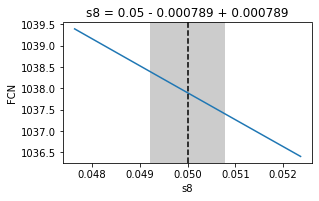

In [33]:
plt.figure(figsize=(8, 5))
plt.subplot(222)
bin_results_to_check.draw_mnprofile('s8', bound=3)
plt.tight_layout()
plt.show()

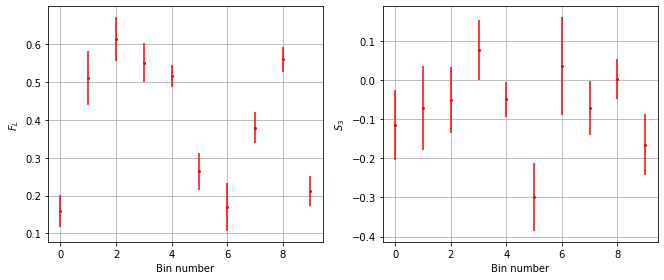

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14/1.5, 6/1.5))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), fls, yerr=fl_errs, fmt='o', markersize=2, label=r'$F_L$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s3s, yerr=s3_errs, fmt='o', markersize=2, label=r'$S_3$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$F_L$')
ax2.set_ylabel(r'$S_3$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()

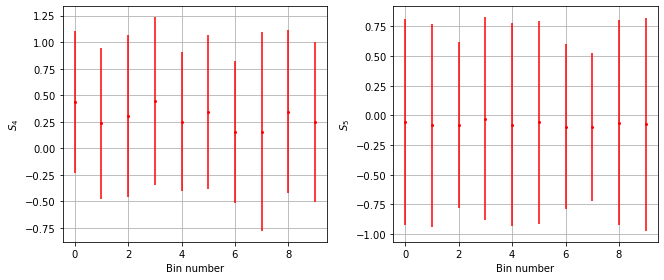

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14/1.5, 6/1.5))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s4s, yerr=s4_errs, fmt='o', markersize=2, label=r'$S_4$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s5s, yerr=s5_errs, fmt='o', markersize=2, label=r'$S_5$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$S_4$')
ax2.set_ylabel(r'$S_5$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()

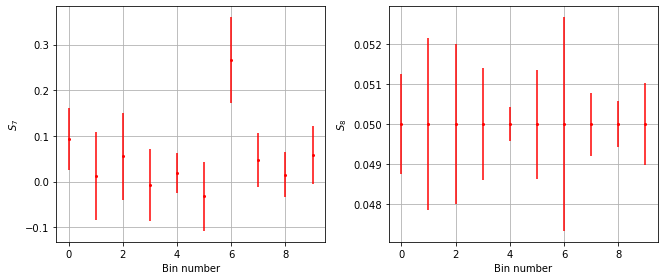

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14/1.5, 6/1.5))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s7s, yerr=s7_errs, fmt='o', markersize=2, label=r'$S_7$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s8s, yerr=s8_errs, fmt='o', markersize=2, label=r'$S_8$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$S_7$')
ax2.set_ylabel(r'$S_8$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()

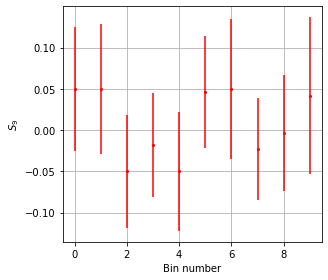

In [37]:
fig, (ax1) = plt.subplots(1,figsize=(14/3, 12/3))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), s9s, yerr=s9_errs, fmt='o', markersize=2, label=r'$S_9$', color='red')
ax1.grid()
ax1.set_ylabel(r'$S_9$')
ax1.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()

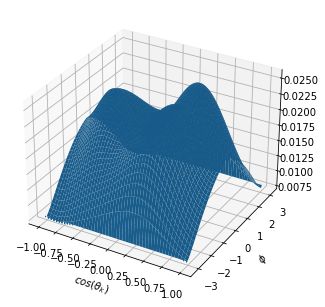

In [40]:
#THETA K + PHI
from mpl_toolkits.mplot3d import Axes3D
bin_to_plot = 0 #select the bin to plot
number_of_bins_in_hist = 25#number of bins of histogram, for 2D 25X25
cos_theta_k_bin = bins[bin_to_plot]['costhetak']  #creating the bins for the angle


hist, xedges, yedges = np.histogram2d(bins[bin_to_plot]['phi'], bins[bin_to_plot]['costhetak'],bins=(number_of_bins_in_hist,number_of_bins_in_hist), density = False)
dz = hist.ravel()/number_of_bins_in_hist
x1 = np.linspace(-1, 1, number_of_bins_in_hist) #costhetak
x2= np.linspace(-np.pi, np.pi, number_of_bins_in_hist) #phi
xpos, ypos = np.meshgrid(xedges[:-1] + 1/number_of_bins_in_hist, yedges[:-1] + 1/number_of_bins_in_hist, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

#hist, _bins, _ = plt.hist(cos_theta_k_bin, bins=number_of_bins_in_hist)



pdf_multiplier = np.sum(dz) *(np.max(phi_bin)-np.min(phi_bin))* (np.max(cos_theta_k_bin) - np.min(cos_theta_k_bin)) / number_of_bins_in_hist**2
X1 = np.linspace(-1, 1, 2000) #costhetak
X2= np.linspace(-np.pi, np.pi, 2000) #phi

X,Y = np.meshgrid(X1, X2)

Z=[]
for i in range(2000): #x
    Z.append([])
    for j in range(2000): #y
        Z[i].append(pdf_multiplier*d2gamma_p_d2q2_dphi_dcosthetak(fl=fls[bin_to_plot],s3=s3s[bin_to_plot], s4=s4s[bin_to_plot], s5=s5s[bin_to_plot], s7=s7s[bin_to_plot], s8=s8s[bin_to_plot], s9=s9s[bin_to_plot], phi=X2[j],cos_theta_k=X1[i]))

fig = plt.figure(29)
ax = Axes3D(fig)
ax.plot_surface(X, Y,np.array(Z))
plt.xlabel(r'$cos(\theta_k)$')
plt.ylabel(r'$\phi$')
plt.show()



Text(0.5, 0, '$\\phi$')

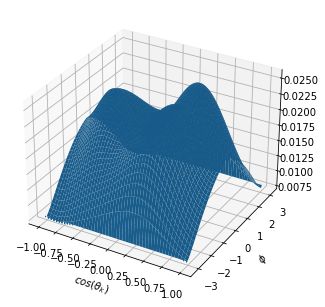

In [41]:
fig = plt.figure(29)
ax = Axes3D(fig)
ax.plot_surface(X, Y,np.array(Z))
plt.xlabel(r'$cos(\theta_k)$')
plt.ylabel(r'$\phi$')




In [44]:
plt.figure(30)
hist, xedges, yedges = np.histogram2d(bins[bin_to_plot]['phi'], bins[bin_to_plot]['costhetak'],bins=(number_of_bins_in_hist,number_of_bins_in_hist), density = False)
dz = hist.ravel()/number_of_bins_in_hist
x1 = np.linspace(-1, 1, number_of_bins_in_hist) #costhetak
x2= np.linspace(-np.pi, np.pi, number_of_bins_in_hist) #phi
xpos, ypos = np.meshgrid(xedges[:-1] + 1/number_of_bins_in_hist, yedges[:-1] + 1/number_of_bins_in_hist, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 10/number_of_bins_in_hist
ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
plt.show()

<Figure size 432x288 with 0 Axes>